PHẦN 1: IMPORT CÁC THƯ VIỆN

In [10]:
# ============================================
# PHẦN 1: IMPORT THƯ VIỆN
# ============================================
"""
Import tất cả thư viện cần thiết cho dự án.
Chạy phần này đầu tiên để đảm bảo mọi thư viện đã được cài đặt.
"""

import os
import time
import itertools

# Thư viện xử lý dữ liệu và hình ảnh
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# Thư viện machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Thư viện deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

# Ẩn cảnh báo
import warnings
warnings.filterwarnings("ignore")

print("✅ Đã import tất cả thư viện thành công!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

✅ Đã import tất cả thư viện thành công!
TensorFlow version: 2.20.0
Num GPUs Available: 0


PHẦN 2: HÀM CHIA DỮ LIỆU


In [11]:
# ============================================
# PHẦN 2: HÀM CHIA DỮ LIỆU
# ============================================
"""
Hàm đọc file CSV và chia dữ liệu thành train, validation, test.
Tỷ lệ: 80% train, 10% validation, 10% test.
"""

def split_data(data_dir, csv_dir):
    """
    Chia dữ liệu từ file CSV thành các tập train, validation, test.
    
    Parameters:
        data_dir: Đường dẫn thư mục chứa ảnh
        csv_dir: Đường dẫn file CSV (chứa tên file và nhãn)
    
    Returns:
        train_df, valid_df, test_df: DataFrames cho từng tập
    """
    
    try:
        # Đọc file CSV
        print(f"📖 Đang đọc file CSV: {csv_dir}")
        df = pd.read_csv(csv_dir)
        
        # Đảm bảo cột có tên đúng
        if len(df.columns) >= 2:
            df.columns = ['filepaths', 'labels']
        else:
            raise ValueError("File CSV phải có ít nhất 2 cột")
        
        # Thêm đường dẫn đầy đủ cho ảnh
        df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(data_dir, x))
        
        # Kiểm tra xem file ảnh có tồn tại không
        missing_files = []
        for filepath in df['filepaths']:
            if not os.path.exists(filepath):
                missing_files.append(filepath)
        
        if missing_files:
            print(f"⚠️  Cảnh báo: {len(missing_files)} file ảnh không tồn tại")
            if len(missing_files) <= 5:
                for mf in missing_files[:5]:
                    print(f"   - {mf}")
        
        print(f"📊 Tổng số mẫu: {len(df)}")
        print(f"📊 Số lớp: {df['labels'].nunique()}")
        print(f"📊 Các lớp: {list(df['labels'].unique())}")
        
        # Chia dữ liệu: 80% train, 20% tạm thời
        strat = df['labels']
        train_df, dummy_df = train_test_split(
            df, 
            train_size=0.8, 
            shuffle=True, 
            random_state=123, 
            stratify=strat
        )
        
        # Chia 20% còn lại: 50% validation, 50% test
        strat = dummy_df['labels']
        valid_df, test_df = train_test_split(
            dummy_df, 
            train_size=0.5, 
            shuffle=True, 
            random_state=123, 
            stratify=strat
        )
        
        # In thống kê
        print("\n📈 THỐNG KÊ CHIA DỮ LIỆU:")
        print(f"   - Train: {len(train_df)} mẫu ({len(train_df)/len(df)*100:.1f}%)")
        print(f"   - Validation: {len(valid_df)} mẫu ({len(valid_df)/len(df)*100:.1f}%)")
        print(f"   - Test: {len(test_df)} mẫu ({len(test_df)/len(df)*100:.1f}%)")
        
        # Kiểm tra phân phối lớp
        print("\n📊 PHÂN PHỐI LỚP TRONG MỖI TẬP:")
        for name, dataset in [("Train", train_df), ("Validation", valid_df), ("Test", test_df)]:
            print(f"   {name}:")
            class_counts = dataset['labels'].value_counts()
            for cls, count in class_counts.items():
                print(f"     - {cls}: {count} mẫu ({count/len(dataset)*100:.1f}%)")
        
        return train_df, valid_df, test_df
        
    except FileNotFoundError:
        print(f"❌ Lỗi: Không tìm thấy file {csv_dir}")
        raise
    except pd.errors.EmptyDataError:
        print(f"❌ Lỗi: File CSV {csv_dir} trống")
        raise
    except Exception as e:
        print(f"❌ Lỗi khi đọc file CSV: {e}")
        raise

print("✅ Đã định nghĩa hàm split_data")

✅ Đã định nghĩa hàm split_data


PHẦN 3: HÀM TẠO DATA GENERATOR


In [12]:
# ============================================
# PHẦN 3: HÀM TẠO DATA GENERATOR
# ============================================
"""
Tạo ImageDataGenerator cho train, validation và test.
Data generator giúp tải ảnh theo batch, thực hiện data augmentation.
"""

def create_gens(train_df, valid_df, test_df, batch_size=32):
    """
    Tạo data generators cho training, validation và testing.
    
    Parameters:
        train_df: DataFrame chứa dữ liệu training
        valid_df: DataFrame chứa dữ liệu validation
        test_df: DataFrame chứa dữ liệu test
        batch_size: Số mẫu mỗi batch (mặc định: 32)
    
    Returns:
        train_gen, valid_gen, test_gen: Các data generators
        test_steps: Số steps cho test set
        test_batch_size: Batch size cho test set
    """
    
    # Cấu hình ảnh
    img_size = (224, 224)  # Kích thước MobileNetV2 yêu cầu
    color = 'rgb'          # Ảnh màu
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    
    # Tính batch size tối ưu cho test set
    ts_length = len(test_df)
    # Tìm batch size lớn nhất mà <= 80
    possible_batch_sizes = []
    for n in range(1, ts_length + 1):
        if ts_length % n == 0 and ts_length / n <= 80:
            possible_batch_sizes.append(n)
    
    test_batch_size = max(possible_batch_sizes) if possible_batch_sizes else 1
    test_steps = ts_length // test_batch_size
    
    print(f"📐 Batch size test set: {test_batch_size}")
    print(f"📐 Số steps test: {test_steps}")
    
    # Hàm tiền xử lý (có thể tùy chỉnh)
    def scalar(img):
        return img
    
    # Tạo generator cho training với data augmentation
    print("\n🔄 Tạo Data Generators...")
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,      # Lật ngang
        rotation_range=15,         # Xoay ±15 độ
        zoom_range=0.1,            # Zoom 0.9-1.1
        width_shift_range=0.1,     # Dịch ngang
        height_shift_range=0.1,    # Dịch dọc
        brightness_range=[0.9, 1.1]# Độ sáng
    )
    
    # Generator cho validation và test (không augmentation)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)
    
    try:
        # Tạo generator cho training
        train_gen = tr_gen.flow_from_dataframe(
            train_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='categorical',
            color_mode=color,
            shuffle=True,
            batch_size=batch_size,
            validate_filenames=True  # Kiểm tra file tồn tại
        )
        
        # Tạo generator cho validation
        valid_gen = ts_gen.flow_from_dataframe(
            valid_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='categorical',
            color_mode=color,
            shuffle=True,
            batch_size=batch_size,
            validate_filenames=True
        )
        
        # Tạo generator cho test (không shuffle)
        test_gen = ts_gen.flow_from_dataframe(
            test_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='categorical',
            color_mode=color,
            shuffle=False,  # Không shuffle để giữ nguyên thứ tự
            batch_size=test_batch_size,
            validate_filenames=True
        )
        
        print("✅ Đã tạo Data Generators thành công!")
        print(f"   - Số lớp: {len(train_gen.class_indices)}")
        print(f"   - Class indices: {train_gen.class_indices}")
        
        return train_gen, valid_gen, test_gen, test_steps, test_batch_size
        
    except Exception as e:
        print(f"❌ Lỗi khi tạo data generators: {e}")
        # Cung cấp thông tin debug
        print("\n🔍 THÔNG TIN DEBUG:")
        print(f"   - Số mẫu train: {len(train_df)}")
        print(f"   - Số mẫu validation: {len(valid_df)}")
        print(f"   - Số mẫu test: {len(test_df)}")
        print(f"   - Batch size: {batch_size}")
        raise

print("✅ Đã định nghĩa hàm create_gens")

✅ Đã định nghĩa hàm create_gens


PHẦN 4: HÀM HIỂN THỊ ẢNH MẪU


In [13]:
# ============================================
# PHẦN 4: HÀM HIỂN THỊ ẢNH MẪU
# ============================================
"""
Hiển thị 25 ảnh mẫu từ generator để kiểm tra dữ liệu.
"""

def show_images(gen, title="Sample Images"):
    """
    Hiển thị các ảnh mẫu từ generator.
    
    Parameters:
        gen: Data generator
        title: Tiêu đề hình ảnh
    """
    
    try:
        # Lấy thông tin từ generator
        g_dict = gen.class_indices        # Dictionary {class: index}
        classes = list(g_dict.keys())     # Danh sách tên lớp
        images, labels = next(gen)        # Lấy một batch
        
        # Tính số ảnh cần hiển thị (tối đa 25)
        length = len(labels)
        sample = min(length, 25)
        
        print(f"📷 Hiển thị {sample} ảnh mẫu từ {title}")
        
        # Tạo figure
        plt.figure(figsize=(15, 15))
        plt.suptitle(title, fontsize=16, y=1.02)
        
        for i in range(sample):
            plt.subplot(5, 5, i + 1)
            
            # Chuẩn hóa ảnh về [0, 1] nếu cần
            if images[i].max() > 1.0:
                image = images[i] / 255.0
            else:
                image = images[i]
            
            # Hiển thị ảnh
            plt.imshow(image)
            
            # Lấy nhãn
            index = np.argmax(labels[i])
            class_name = classes[index]
            
            # Đặt tiêu đề
            plt.title(class_name, color='blue', fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Hiển thị thông tin batch
        print(f"   - Kích thước batch: {images.shape}")
        print(f"   - Giá trị pixel min/max: {images.min():.1f}/{images.max():.1f}")
        print(f"   - Số kênh màu: {images.shape[-1]}")
        
    except Exception as e:
        print(f"❌ Lỗi khi hiển thị ảnh: {e}")
        print("   - Kiểm tra generator có dữ liệu không")
        print("   - Kiểm tra định dạng ảnh")

print("✅ Đã định nghĩa hàm show_images")

✅ Đã định nghĩa hàm show_images


PHẦN 5: CUSTOM CALLBACK CLASS


In [14]:
# ============================================
# PHẦN 5: CUSTOM CALLBACK CLASS
# ============================================
"""
Custom callback để quản lý quá trình training:
- Điều chỉnh learning rate tự động
- Dừng training sớm nếu không cải thiện
- Lưu model tốt nhất
"""

class MyCallback(keras.callbacks.Callback):
    """
    Custom callback với các tính năng:
    1. Điều chỉnh learning rate dựa trên độ chính xác/val_loss
    2. Dừng training sớm nếu không cải thiện sau nhiều lần
    3. Lưu weights tốt nhất
    4. Hiển thị thông tin chi tiết mỗi epoch
    """
    
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        
        # Tham số
        self._model = model
        self.patience = patience          # Số epoch không cải thiện trước khi giảm LR
        self.stop_patience = stop_patience # Số lần giảm LR tối đa trước khi dừng
        self.threshold = threshold        # Ngưỡng accuracy (0.9 = 90%)
        self.factor = factor              # Hệ số giảm LR (0.5 = giảm một nửa)
        self.batches = batches            # Số batch mỗi epoch
        self.epochs = epochs              # Tổng số epoch
        self.ask_epoch = ask_epoch        # Epoch để hỏi có tiếp tục không
        
        # Biến trạng thái
        self.count = 0                    # Đếm số epoch không cải thiện
        self.stop_count = 0               # Đếm số lần giảm LR
        self.best_epoch = 1               # Epoch tốt nhất
        self.initial_lr = float(model.optimizer.learning_rate.numpy())
        self.highest_tracc = 0.0          # Độ chính xác training cao nhất
        self.lowest_vloss = np.inf        # Val loss thấp nhất
        self.best_weights = self._model.get_weights()  # Weights tốt nhất
        self.initial_weights = self._model.get_weights()  # Weights ban đầu
        
        print(f"✅ Đã khởi tạo callback với:")
        print(f"   - Patience: {patience} epoch")
        print(f"   - Stop patience: {stop_patience} lần")
        print(f"   - Threshold accuracy: {threshold}")
        print(f"   - LR factor: {factor}")
        print(f"   - Initial LR: {self.initial_lr}")
    
    def on_train_begin(self, logs=None):
        """Khởi tạo khi bắt đầu training"""
        print("\n" + "="*80)
        print("🚀 BẮT ĐẦU TRAINING")
        print("="*80)
        
        # In header
        header = f"{'Epoch':^8}{'Loss':^10}{'Acc':^9}{'V_Loss':^9}{'V_Acc':^9}{'LR':^9}{'Next LR':^9}{'Monitor':^11}{'%Improv':^10}{'Time':^8}"
        print(header)
        print("-"*80)
        
        self.start_time = time.time()
    
    def on_epoch_begin(self, epoch, logs=None):
        """Bắt đầu mỗi epoch"""
        self.ep_start = time.time()
    
    def on_train_batch_end(self, batch, logs=None):
        """Kết thúc mỗi batch"""
        if batch % max(1, self.batches // 10) == 0:  # In 10 lần mỗi epoch
            acc = logs.get('accuracy') * 100
            loss = logs.get('loss')
            
            # In tiến trình
            msg = f"{' ':20s}Batch {batch:3d}/{self.batches:3d} - acc: {acc:5.2f}% - loss: {loss:6.4f}"
            print(msg, end='\r', flush=True)
    
    def on_epoch_end(self, epoch, logs=None):
        """Kết thúc mỗi epoch - logic chính"""
        # Lấy các giá trị metrics
        lr = float(self._model.optimizer.learning_rate.numpy())
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')
        duration = time.time() - self.ep_start
        
        # Logic điều chỉnh learning rate
        if acc < self.threshold:
            # Nếu accuracy còn thấp, monitor accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if self.highest_tracc > 0 else 0.0
            
            if acc > self.highest_tracc:
                # Cải thiện accuracy
                self.highest_tracc = acc
                self.best_weights = self._model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
            else:
                # Không cải thiện
                if self.count >= self.patience - 1:
                    # Giảm learning rate
                    lr = lr * self.factor
                    self._model.optimizer.learning_rate.assign(lr)
                    self.count = 0
                    self.stop_count += 1
                    print(f"   ⬇️  Giảm LR xuống: {lr:.6f}")
                else:
                    self.count += 1
        else:
            # Nếu accuracy đã cao, monitor validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if self.lowest_vloss < np.inf else 0.0
            
            if v_loss < self.lowest_vloss:
                # Cải thiện validation loss
                self.lowest_vloss = v_loss
                self.best_weights = self._model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                # Không cải thiện
                if self.count >= self.patience - 1:
                    # Giảm learning rate
                    lr = lr * self.factor
                    self._model.optimizer.learning_rate.assign(lr)
                    self.stop_count += 1
                    self.count = 0
                    print(f"   ⬇️  Giảm LR xuống: {lr:.6f}")
                else:
                    self.count += 1
        
        # In thông tin epoch
        msg = f"{epoch+1:^8d}{loss:^10.4f}{acc*100:^9.2f}{v_loss:^9.4f}{v_acc*100:^9.2f}" + \
              f"{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}"
        print(msg)
        
        # Kiểm tra có nên dừng không
        if self.stop_count > self.stop_patience - 1:
            print(f"\n⏹️  Dừng training tại epoch {epoch+1} (không cải thiện sau {self.stop_patience} lần điều chỉnh LR)")
            self._model.stop_training = True
    
    def on_train_end(self, logs=None):
        """Kết thúc training"""
        # Tính thời gian training
        total_time = time.time() - self.start_time
        hours = int(total_time // 3600)
        minutes = int((total_time % 3600) // 60)
        seconds = total_time % 60
        
        # Khôi phục weights tốt nhất
        self._model.set_weights(self.best_weights)
        
        print("\n" + "="*80)
        print("✅ HOÀN THÀNH TRAINING")
        print("="*80)
        print(f"   Thời gian: {hours} giờ, {minutes} phút, {seconds:.2f} giây")
        print(f"   Epoch tốt nhất: {self.best_epoch}")
        print(f"   Validation loss tốt nhất: {self.lowest_vloss:.4f}")
        print(f"   Training accuracy tốt nhất: {self.highest_tracc:.4f} ({self.highest_tracc*100:.2f}%)")
        print("="*80)

print("✅ Đã định nghĩa class MyCallback")

✅ Đã định nghĩa class MyCallback


PHẦN 6: HÀM VẼ BIỂU ĐỒ


In [15]:
# ============================================
# PHẦN 6: HÀM VẼ BIỂU ĐỒ
# ============================================
"""
Các hàm để visualize quá trình training và kết quả:
- Biểu đồ loss và accuracy
- Confusion matrix
"""

def plot_training(hist):
    """
    Vẽ biểu đồ loss và accuracy qua các epoch.
    
    Parameters:
        hist: History object từ model.fit()
    """
    
    try:
        # Lấy dữ liệu từ history
        tr_acc = hist.history['accuracy']
        tr_loss = hist.history['loss']
        val_acc = hist.history['val_accuracy']
        val_loss = hist.history['val_loss']
        
        # Tìm điểm tốt nhất
        index_loss = np.argmin(val_loss)
        val_lowest = val_loss[index_loss]
        index_acc = np.argmax(val_acc)
        acc_highest = val_acc[index_acc]
        
        # Tạo danh sách epoch
        epochs = [i+1 for i in range(len(tr_acc))]
        
        print(f"\n📊 KẾT QUẢ TRAINING TỐT NHẤT:")
        print(f"   - Validation loss thấp nhất: {val_lowest:.4f} (epoch {index_loss+1})")
        print(f"   - Validation accuracy cao nhất: {acc_highest:.4f} ({acc_highest*100:.2f}%) (epoch {index_acc+1})")
        
        # Vẽ biểu đồ
        plt.figure(figsize=(18, 6))
        
        # Biểu đồ Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, tr_loss, 'r-', label='Training Loss', linewidth=2)
        plt.plot(epochs, val_loss, 'b-', label='Validation Loss', linewidth=2)
        plt.scatter(index_loss+1, val_lowest, s=200, c='red', 
                    label=f'Best: {val_lowest:.4f}', zorder=5)
        plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        
        # Biểu đồ Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, tr_acc, 'r-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy', linewidth=2)
        plt.scatter(index_acc+1, acc_highest, s=200, c='red',
                    label=f'Best: {acc_highest:.4f}', zorder=5)
        plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Lỗi khi vẽ biểu đồ training: {e}")
        print("   - Kiểm tra history object")


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    Vẽ và hiển thị confusion matrix.
    
    Parameters:
        cm: Confusion matrix array
        classes: Danh sách tên lớp
        normalize: Chuẩn hóa theo hàng nếu True
        title: Tiêu đề biểu đồ
    """
    
    try:
        plt.figure(figsize=(12, 10))
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("\n📊 CONFUSION MATRIX (Chuẩn hóa):")
        else:
            print("\n📊 CONFUSION MATRIX:")
        
        # Hiển thị confusion matrix
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.colorbar(fraction=0.046, pad=0.04)
        
        # Đặt nhãn trục
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=10)
        plt.yticks(tick_marks, classes, fontsize=10)
        
        # Định dạng số trong ô
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                value = f"{cm[i, j]:.2f}"
            else:
                value = f"{cm[i, j]}"
            plt.text(j, i, value,
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=9 if len(classes) <= 10 else 8)
        
        plt.tight_layout()
        plt.ylabel('Nhãn thực tế', fontsize=12)
        plt.xlabel('Nhãn dự đoán', fontsize=12)
        plt.show()
        
        # In thông tin chi tiết
        if not normalize:
            total = cm.sum()
            correct = cm.diagonal().sum()
            accuracy = correct / total
            print(f"   - Tổng mẫu: {total}")
            print(f"   - Dự đoán đúng: {correct}")
            print(f"   - Độ chính xác tổng: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
    except Exception as e:
        print(f"❌ Lỗi khi vẽ confusion matrix: {e}")

print("✅ Đã định nghĩa các hàm vẽ biểu đồ")

✅ Đã định nghĩa các hàm vẽ biểu đồ


PHẦN 7: TẠO VÀ COMPILE MÔ HÌNH


In [16]:
# ============================================
# PHẦN 7: TẠO VÀ COMPILE MÔ HÌNH
# ============================================
"""
Tạo mô hình MobileNetV2 với transfer learning.
Thêm các layer custom và compile model.
"""

def create_mobilenetv2_model(img_shape, class_count):
    """
    Tạo mô hình MobileNetV2 với transfer learning.
    
    Parameters:
        img_shape: Kích thước ảnh input (height, width, channels)
        class_count: Số lớp cần phân loại
    
    Returns:
        model: Mô hình đã được compile
    """
    
    print("\n🔨 ĐANG XÂY DỰNG MÔ HÌNH MOBILENETV2...")
    
    try:
        # Tạo base model (MobileNetV2)
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False,        # Không include lớp fully connected cuối
            weights='imagenet',       # Sử dụng weights pretrained trên ImageNet
            input_shape=img_shape,    # Kích thước input
            pooling='max'            # Global max pooling
        )
        
        # Đóng băng các layer của base model
        base_model.trainable = False
        print(f"   - Đã đóng băng {len(base_model.layers)} layers của base model")
        
        # Xây dựng model hoàn chỉnh
        model = Sequential([
            # Base model
            base_model,
            
            # Batch normalization
            BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
            
            # Fully connected layer với regularization
            Dense(256,
                  kernel_regularizer=regularizers.l2(0.016),  # L2 regularization
                  activity_regularizer=regularizers.l1(0.006), # L1 regularization
                  bias_regularizer=regularizers.l1(0.006),     # Bias regularization
                  activation='relu'),
            
            # Dropout để tránh overfitting
            Dropout(rate=0.45, seed=123),
            
            # Output layer
            Dense(class_count, activation='softmax')
        ])
        
        # Compile model
        model.compile(
            optimizer=Adamax(learning_rate=0.001),  # Optimizer
            loss='categorical_crossentropy',        # Loss function
            metrics=['accuracy']                    # Evaluation metric
        )
        
        print("✅ ĐÃ TẠO MÔ HÌNH THÀNH CÔNG!")
        print(f"   - Số lớp đầu ra: {class_count}")
        print(f"   - Kích thước input: {img_shape}")
        print(f"   - Optimizer: Adamax với LR=0.001")
        
        return model
        
    except Exception as e:
        print(f"❌ Lỗi khi tạo model: {e}")
        print("   - Kiểm tra kết nối internet để tải weights")
        print("   - Kiểm tra version TensorFlow")
        raise

print("✅ Đã định nghĩa hàm create_mobilenetv2_model")

✅ Đã định nghĩa hàm create_mobilenetv2_model


PHẦN 8: HÀM CHÍNH - CHẠY TOÀN BỘ QUY TRÌNH


In [17]:
# ============================================
# PHẦN 8: HÀM CHÍNH - CHẠY TOÀN BỘ QUY TRÌNH
# ============================================
"""
Hàm chính thực hiện toàn bộ quy trình từ đầu đến cuối.
"""

def main():
    """
    Hàm chính thực hiện toàn bộ pipeline:
    1. Chuẩn bị dữ liệu
    2. Tạo data generators
    3. Xây dựng model
    4. Training
    5. Đánh giá
    6. Lưu model
    """
    
    print("="*80)
    print("🤖 BẮT ĐẦU CHƯƠNG TRÌNH PHÂN LOẠI BỆNH GÀ")
    print("="*80)
    
    # ==================== BƯỚC 1: THIẾT LẬP THAM SỐ ====================
    print("\n1. ⚙️  THIẾT LẬP THAM SỐ")
    
    # Đường dẫn dữ liệu - THAY ĐỔI Ở ĐÂY THEO CẤU TRÚC DỮ LIỆU CỦA BẠN
    data_dir = './Train'           # Thư mục chứa ảnh
    csv_dir = 'train_data.csv'     # File CSV chứa thông tin
    
    # Tham số training
    batch_size = 32                # Số mẫu mỗi batch
    epochs = 30                    # Số epoch training
    img_size = (224, 224)         # Kích thước ảnh cho MobileNetV2
    
    print(f"   - Data directory: {data_dir}")
    print(f"   - CSV file: {csv_dir}")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Epochs: {epochs}")
    print(f"   - Image size: {img_size}")
    
    # ==================== BƯỚC 2: CHUẨN BỊ DỮ LIỆU ====================
    print("\n2. 📁 CHUẨN BỊ DỮ LIỆU")
    
    # Kiểm tra file tồn tại
    if not os.path.exists(csv_dir):
        print(f"❌ LỖI: Không tìm thấy file {csv_dir}")
        print("   Vui lòng đảm bảo file train_data.csv tồn tại trong thư mục hiện tại")
        print("   Hoặc thay đổi đường dẫn trong biến csv_dir")
        return None, None
    
    if not os.path.exists(data_dir):
        print(f"❌ LỖI: Không tìm thấy thư mục {data_dir}")
        print("   Vui lòng đảm bảo thư mục Train tồn tại")
        print("   Hoặc thay đổi đường dẫn trong biến data_dir")
        return None, None
    
    # Chia dữ liệu
    try:
        train_df, valid_df, test_df = split_data(data_dir, csv_dir)
    except Exception as e:
        print(f"❌ Lỗi khi chia dữ liệu: {e}")
        return None, None
    
    # ==================== BƯỚC 3: TẠO DATA GENERATORS ====================
    print("\n3. 🔄 TẠO DATA GENERATORS")
    
    try:
        train_gen, valid_gen, test_gen, test_steps, test_batch_size = create_gens(
            train_df, valid_df, test_df, batch_size
        )
    except Exception as e:
        print(f"❌ Lỗi khi tạo data generators: {e}")
        return None, None
    
    # Hiển thị ảnh mẫu
    show_images(train_gen, "Training Images Sample")
    
    # ==================== BƯỚC 4: TẠO MÔ HÌNH ====================
    print("\n4. 🔨 XÂY DỰNG MÔ HÌNH")
    
    img_shape = (img_size[0], img_size[1], 3)
    class_count = len(list(train_gen.class_indices.keys()))
    
    try:
        model = create_mobilenetv2_model(img_shape, class_count)
    except Exception as e:
        print(f"❌ Lỗi khi tạo model: {e}")
        return None, None
    
    # In summary
    print("\n📋 MODEL SUMMARY:")
    model.summary()
    
    # ==================== BƯỚC 5: THIẾT LẬP CALLBACKS ====================
    print("\n5. ⏱️  THIẾT LẬP CALLBACKS")
    
    # Tính số batches mỗi epoch
    batches = int(np.ceil(len(train_gen.labels) / batch_size))
    
    # Tạo callback
    callbacks = [MyCallback(
        model=model,
        patience=1,           # Số epoch không cải thiện trước khi giảm LR
        stop_patience=3,      # Số lần giảm LR tối đa trước khi dừng
        threshold=0.9,        # Ngưỡng accuracy (90%)
        factor=0.5,           # Hệ số giảm LR
        batches=batches,
        epochs=epochs,
        ask_epoch=5
    )]
    
    # ==================== BƯỚC 6: TRAINING ====================
    print("\n6. 🏋️‍♂️ BẮT ĐẦU TRAINING")
    
    try:
        history = model.fit(
            x=train_gen,
            epochs=epochs,
            verbose=0,           # Không in mặc định (sử dụng custom callback)
            callbacks=callbacks,
            validation_data=valid_gen,
            validation_steps=None,
            shuffle=False
        )
    except Exception as e:
        print(f"❌ Lỗi trong quá trình training: {e}")
        print("   - Kiểm tra bộ nhớ (giảm batch_size nếu cần)")
        print("   - Kiểm tra dữ liệu input")
        return None, None
    
    # ==================== BƯỚC 7: ĐÁNH GIÁ MÔ HÌNH ====================
    print("\n7. 📊 ĐÁNH GIÁ MÔ HÌNH")
    
    # Vẽ biểu đồ training
    plot_training(history)
    
    # Đánh giá trên các tập
    print("\n🎯 ĐÁNH GIÁ CHI TIẾT:")
    print("-" * 60)
    
    # Training set
    train_score = model.evaluate(train_gen, steps=len(train_gen), verbose=0)
    print(f"📈 TRAIN SET:")
    print(f"   - Loss: {train_score[0]:.4f}")
    print(f"   - Accuracy: {train_score[1]*100:.2f}%")
    
    # Validation set
    valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose=0)
    print(f"\n📊 VALIDATION SET:")
    print(f"   - Loss: {valid_score[0]:.4f}")
    print(f"   - Accuracy: {valid_score[1]*100:.2f}%")
    
    # Test set
    test_score = model.evaluate(test_gen, steps=test_steps, verbose=0)
    print(f"\n🧪 TEST SET:")
    print(f"   - Loss: {test_score[0]:.4f}")
    print(f"   - Accuracy: {test_score[1]*100:.2f}%")
    print("-" * 60)
    
    # ==================== BƯỚC 8: DỰ ĐOÁN VÀ PHÂN TÍCH ====================
    print("\n8. 🔍 PHÂN TÍCH DỰ ĐOÁN")
    
    # Dự đoán trên test set
    try:
        preds = model.predict(test_gen, steps=test_steps, verbose=1)
        y_pred = np.argmax(preds, axis=1)
        
        # Lấy thông tin lớp
        classes = list(test_gen.class_indices.keys())
        
        # Confusion matrix
        cm = confusion_matrix(test_gen.classes, y_pred)
        plot_confusion_matrix(cm, classes, title='Confusion Matrix - Test Set')
        
        # Classification report
        print("\n📋 BÁO CÁO PHÂN LOẠI CHI TIẾT:")
        print(classification_report(test_gen.classes, y_pred, 
                                   target_names=classes, digits=4))
    except Exception as e:
        print(f"❌ Lỗi khi dự đoán và phân tích: {e}")
    
    # ==================== BƯỚC 9: LƯU MÔ HÌNH ====================
    print("\n9. 💾 LƯU MÔ HÌNH VÀ KẾT QUẢ")
    
    # Tạo thư mục lưu nếu chưa có
    save_path = './saved_models'
    os.makedirs(save_path, exist_ok=True)
    
    # Lưu model
    acc_percent = test_score[1] * 100
    model_name = 'MobileNetV2'
    subject = 'ChickenDisease'
    
    try:
        # Lưu toàn bộ model (.keras format)
        model_filename = f'{model_name}_{subject}_{acc_percent:.2f}acc.keras'
        model_path = os.path.join(save_path, model_filename)
        model.save(model_path)
        print(f"   ✅ Đã lưu model: {model_path}")
    except Exception as e:
        print(f"   ❌ Lỗi khi lưu model: {e}")
    
    try:
        # SỬA LỖI: Đổi từ _weights.h5 thành .weights.h5
        weights_filename = f'{model_name}_{subject}.weights.h5'  # ĐÃ SỬA LỖI
        weights_path = os.path.join(save_path, weights_filename)
        model.save_weights(weights_path)
        print(f"   ✅ Đã lưu weights: {weights_path}")
    except Exception as e:
        print(f"   ❌ Lỗi khi lưu weights: {e}")
        print(f"   💡 Thử sửa tên file thành: {weights_filename}")
    
    try:
        # Lưu class dictionary
        class_dict = train_gen.class_indices
        class_df = pd.DataFrame({
            'class_index': list(class_dict.values()),
            'class_name': list(class_dict.keys())
        })
        
        class_csv = os.path.join(save_path, f'{subject}_class_mapping.csv')
        class_df.to_csv(class_csv, index=False)
        print(f"   ✅ Đã lưu class mapping: {class_csv}")
    except Exception as e:
        print(f"   ❌ Lỗi khi lưu class mapping: {e}")
    
    try:
        # Lưu training history
        history_df = pd.DataFrame(history.history)
        history_csv = os.path.join(save_path, f'{subject}_training_history.csv')
        history_df.to_csv(history_csv, index=False)
        print(f"   ✅ Đã lưu training history: {history_csv}")
    except Exception as e:
        print(f"   ❌ Lỗi khi lưu training history: {e}")
    
    # ==================== BƯỚC 10: KẾT THÚC ====================
    print("\n" + "="*80)
    print("🎉 HOÀN THÀNH CHƯƠNG TRÌNH!")
    print("="*80)
    print(f"\n📁 Các file đã được lưu trong thư mục: {save_path}")
    print(f"📊 Độ chính xác cuối cùng trên test set: {acc_percent:.2f}%")
    print("\n✨ Bạn có thể sử dụng model đã lưu để dự đoán trên dữ liệu mới!")
    
    return model, history

print("✅ Đã định nghĩa hàm main")

✅ Đã định nghĩa hàm main


PHẦN 9: CHẠY CHƯƠNG TRÌNH


🚀 BẮT ĐẦU CHẠY CHƯƠNG TRÌNH...
📦 TensorFlow version: 2.20.0
🎮 Số GPU khả dụng: 0
💻 Đang chạy trên: CPU

⚠️  LƯU Ý QUAN TRỌNG:
1. Đảm bảo có file 'train_data.csv' trong thư mục hiện tại
2. Đảm bảo có thư mục './Train' chứa ảnh
3. File CSV cần 2 cột: 'filepaths' và 'labels'
4. Tên file weights phải kết thúc bằng '.weights.h5'
🤖 BẮT ĐẦU CHƯƠNG TRÌNH PHÂN LOẠI BỆNH GÀ

1. ⚙️  THIẾT LẬP THAM SỐ
   - Data directory: ./Train
   - CSV file: train_data.csv
   - Batch size: 32
   - Epochs: 30
   - Image size: (224, 224)

2. 📁 CHUẨN BỊ DỮ LIỆU
📖 Đang đọc file CSV: train_data.csv
⚠️  Cảnh báo: 7505 file ảnh không tồn tại
📊 Tổng số mẫu: 8067
📊 Số lớp: 4
📊 Các lớp: ['Salmonella', 'Coccidiosis', 'New Castle Disease', 'Healthy']

📈 THỐNG KÊ CHIA DỮ LIỆU:
   - Train: 6453 mẫu (80.0%)
   - Validation: 807 mẫu (10.0%)
   - Test: 807 mẫu (10.0%)

📊 PHÂN PHỐI LỚP TRONG MỖI TẬP:
   Train:
     - Salmonella: 2100 mẫu (32.5%)
     - Coccidiosis: 1981 mẫu (30.7%)
     - Healthy: 1923 mẫu (29.8%)
     - New Cas

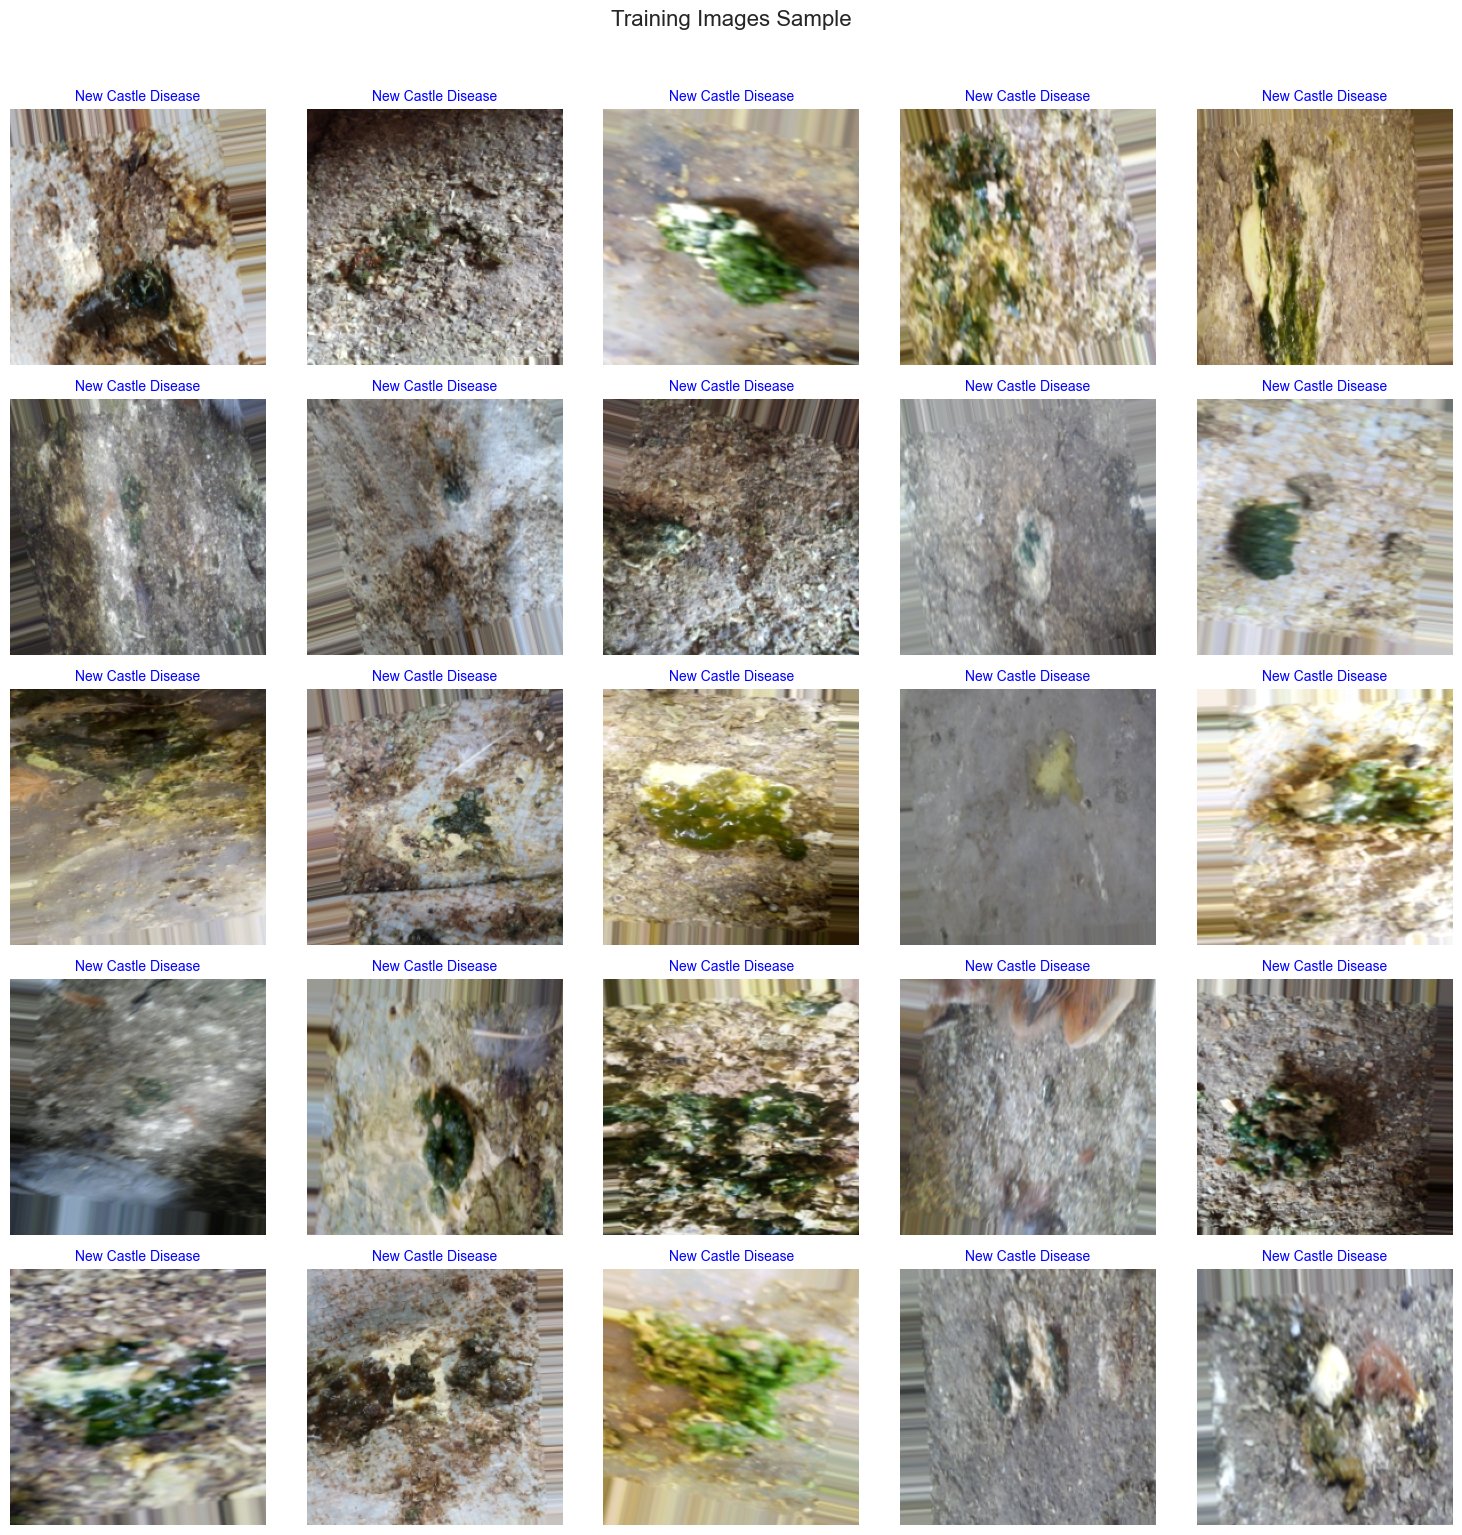

   - Kích thước batch: (32, 224, 224, 3)
   - Giá trị pixel min/max: 0.0/255.0
   - Số kênh màu: 3

4. 🔨 XÂY DỰNG MÔ HÌNH

🔨 ĐANG XÂY DỰNG MÔ HÌNH MOBILENETV2...
   - Đã đóng băng 155 layers của base model
✅ ĐÃ TẠO MÔ HÌNH THÀNH CÔNG!
   - Số lớp đầu ra: 1
   - Kích thước input: (224, 224, 3)
   - Optimizer: Adamax với LR=0.001

📋 MODEL SUMMARY:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,297 (9.89 MB)

 Trainable params: 330,753 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)


5. ⏱️  THIẾT LẬP CALLBACKS
✅ Đã khởi tạo callback với:
   - Patience: 1 epoch
   - Stop patience: 3 lần
   - Threshold accuracy: 0.9
   - LR factor: 0.5
   - Initial LR: 0.0010000000474974513

6. 🏋️‍♂️ BẮT ĐẦU TRAINING

🚀 BẮT ĐẦU TRAINING
 Epoch     Loss      Acc    V_Loss    V_Acc     LR     Next LR   Monitor   %Improv    Time  
--------------------------------------------------------------------------------
   1     26.1927   100.00   42.9325  100.00   0.00100  0.00100  val_loss     0.00    13.39  
   2     22.2103   100.00   33.3673  100.00   0.00100  0.00100  val_loss    22.28     6.76  
   3     19.1621   100.00   27.4900  100.00   0.00100  0.00100  val_loss    17.61     6.38  
   4     16.2626   100.00   21.5896  100.00   0.00100  0.00100  val_loss    21.46     6.29  
   5     13.2074   100.00   16.9244  100.00   0.00100  0.00100  val_loss    21.61     6.72  
   6     10.4032   100.00   12.4640  100.00   0.00100  0.00100  val_loss    26.35     6.85  
   7      8.1131   100.00   

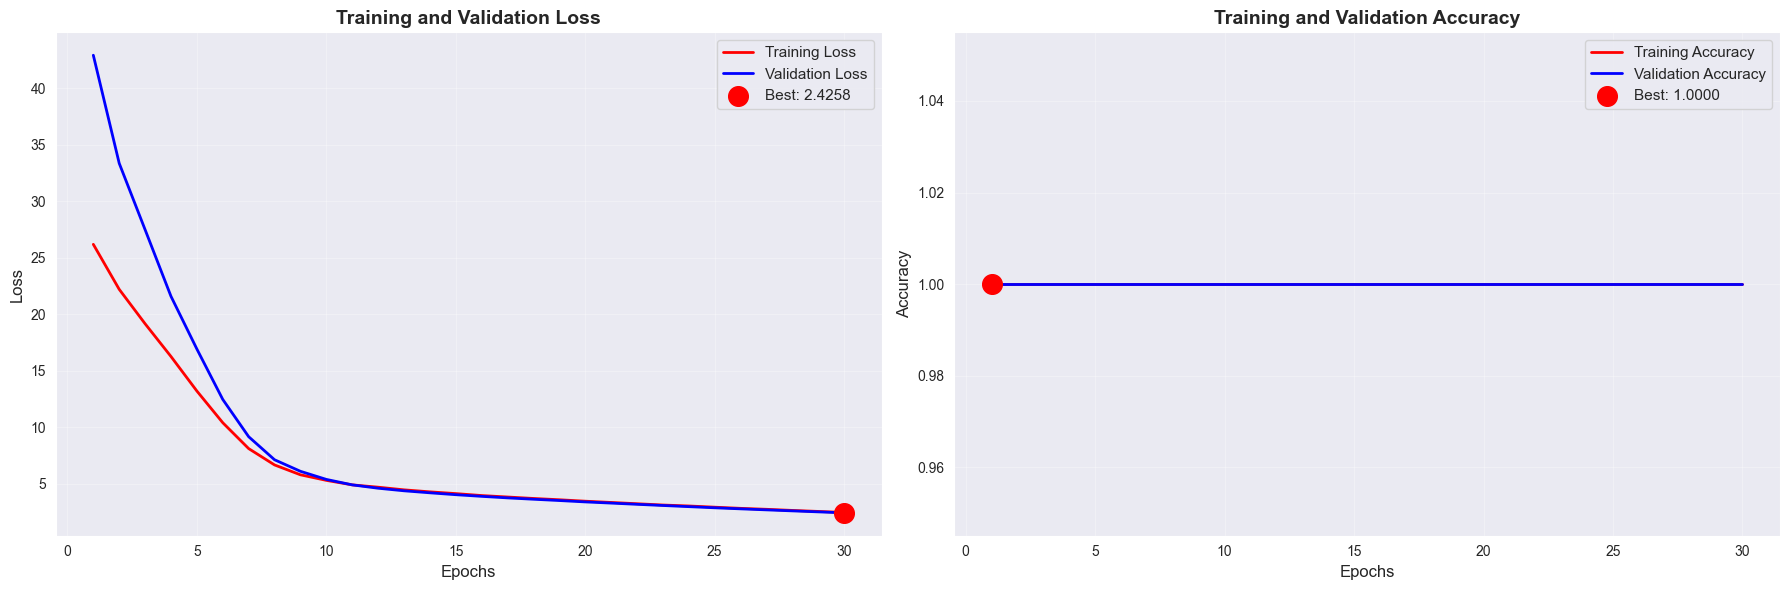


🎯 ĐÁNH GIÁ CHI TIẾT:
------------------------------------------------------------
📈 TRAIN SET:
   - Loss: 2.4561
   - Accuracy: 100.00%

📊 VALIDATION SET:
   - Loss: 2.4261
   - Accuracy: 100.00%

🧪 TEST SET:
   - Loss: 3.0449
   - Accuracy: 100.00%
------------------------------------------------------------

8. 🔍 PHÂN TÍCH DỰ ĐOÁN
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

📊 CONFUSION MATRIX:


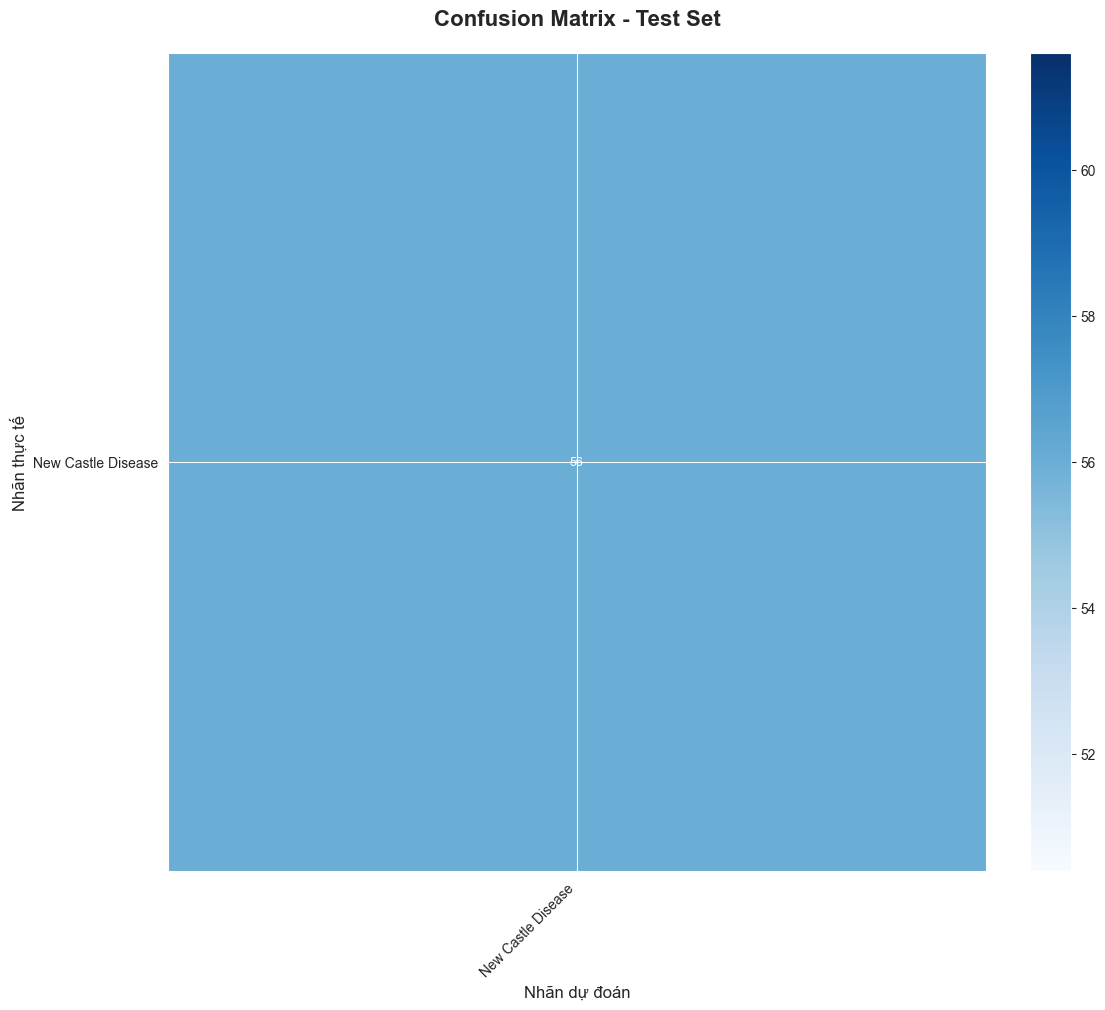

   - Tổng mẫu: 56
   - Dự đoán đúng: 56
   - Độ chính xác tổng: 1.0000 (100.00%)

📋 BÁO CÁO PHÂN LOẠI CHI TIẾT:
                    precision    recall  f1-score   support

New Castle Disease     1.0000    1.0000    1.0000        56

          accuracy                         1.0000        56
         macro avg     1.0000    1.0000    1.0000        56
      weighted avg     1.0000    1.0000    1.0000        56


9. 💾 LƯU MÔ HÌNH VÀ KẾT QUẢ
   ✅ Đã lưu model: ./saved_models\MobileNetV2_ChickenDisease_100.00acc.keras
   ✅ Đã lưu weights: ./saved_models\MobileNetV2_ChickenDisease.weights.h5
   ✅ Đã lưu class mapping: ./saved_models\ChickenDisease_class_mapping.csv
   ✅ Đã lưu training history: ./saved_models\ChickenDisease_training_history.csv

🎉 HOÀN THÀNH CHƯƠNG TRÌNH!

📁 Các file đã được lưu trong thư mục: ./saved_models
📊 Độ chính xác cuối cùng trên test set: 100.00%

✨ Bạn có thể sử dụng model đã lưu để dự đoán trên dữ liệu mới!

✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
CHƯƠNG TRÌNH 

In [18]:
# ============================================
# PHẦN 9: CHẠY CHƯƠNG TRÌNH
# ============================================
"""
Điểm bắt đầu của chương trình.
Chạy phần này để thực thi toàn bộ pipeline.
"""

if __name__ == "__main__":
    """
    Điểm vào chính của chương trình.
    Chạy hàm main() khi script được thực thi trực tiếp.
    """
    
    try:
        print("🚀 BẮT ĐẦU CHẠY CHƯƠNG TRÌNH...")
        print("="*60)
        
        # Kiểm tra TensorFlow version
        print(f"📦 TensorFlow version: {tf.__version__}")
        print(f"🎮 Số GPU khả dụng: {len(tf.config.list_physical_devices('GPU'))}")
        print(f"💻 Đang chạy trên: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")
        
        print("\n⚠️  LƯU Ý QUAN TRỌNG:")
        print("1. Đảm bảo có file 'train_data.csv' trong thư mục hiện tại")
        print("2. Đảm bảo có thư mục './Train' chứa ảnh")
        print("3. File CSV cần 2 cột: 'filepaths' và 'labels'")
        print("4. Tên file weights phải kết thúc bằng '.weights.h5'")
        print("="*60)
        
        # Thực thi hàm main
        model, history = main()
        
        if model is not None and history is not None:
            # Thông báo thành công
            print("\n" + "✨" * 40)
            print("CHƯƠNG TRÌNH ĐÃ CHẠY THÀNH CÔNG!")
            print("✨" * 40)
            
            # Hiển thị các file đã lưu
            print("\n📁 DANH SÁCH FILE ĐÃ LƯU:")
            save_path = './saved_models'
            if os.path.exists(save_path):
                files = os.listdir(save_path)
                if files:
                    for file in files:
                        file_path = os.path.join(save_path, file)
                        if os.path.isfile(file_path):
                            size = os.path.getsize(file_path)
                            if size > 1024*1024:  # MB
                                size_str = f"{size/(1024*1024):.2f} MB"
                            elif size > 1024:  # KB
                                size_str = f"{size/1024:.2f} KB"
                            else:
                                size_str = f"{size} bytes"
                            print(f"   - {file} ({size_str})")
                else:
                    print("   (Không có file nào)")
            else:
                print("   (Thư mục saved_models không tồn tại)")
            
            print("\n✅ HOÀN TẤT!")
            
    except KeyboardInterrupt:
        print("\n\n⏹️  Chương trình đã bị dừng bởi người dùng")
        
    except FileNotFoundError as e:
        print(f"\n❌ LỖI: Không tìm thấy file hoặc thư mục: {e}")
        print("\n🔧 HƯỚNG DẪN KHẮC PHỤC:")
        print("   1. Đảm bảo file 'train_data.csv' tồn tại trong thư mục hiện tại")
        print("   2. Đảm bảo thư mục './Train' tồn tại và chứa ảnh")
        print("   3. Kiểm tra cấu trúc file CSV có đúng định dạng không")
        print("      - Cột 1: filepaths (tên file ảnh)")
        print("      - Cột 2: labels (nhãn phân loại)")
        print("   4. Thay đổi đường dẫn trong hàm main() nếu cần")
        
    except ValueError as e:
        print(f"\n❌ LỖI GIÁ TRỊ: {e}")
        print("\n🔧 NGUYÊN NHÂN THƯỜNG GẶP:")
        print("   1. File CSV không đúng định dạng")
        print("   2. Đường dẫn ảnh trong CSV không chính xác")
        print("   3. Lỗi lưu weights - đã được sửa trong code")
        print("   4. Dữ liệu không đúng định dạng")
        
    except MemoryError as e:
        print(f"\n❌ LỖI BỘ NHỚ: {e}")
        print("\n🔧 HƯỚNG DẪN KHẮC PHỤC:")
        print("   1. Giảm batch_size trong hàm main (dòng: batch_size = 32)")
        print("      → Thử: batch_size = 16 hoặc 8")
        print("   2. Giảm kích thước ảnh (img_size = (224, 224))")
        print("      → Thử: img_size = (128, 128)")
        print("   3. Giảm số epoch (epochs = 30)")
        print("      → Thử: epochs = 15 hoặc 20")
        print("   4. Sử dụng GPU nếu có")
        
    except Exception as e:
        print(f"\n❌ LỖI KHÔNG XÁC ĐỊNH: {e}")
        print(f"\n📋 Chi tiết lỗi:")
        import traceback
        traceback.print_exc()
        
        print("\n🔧 HƯỚNG DẪN KHẮC PHỤC CHUNG:")
        print("   1. Kiểm tra cài đặt TensorFlow:")
        print("      pip install --upgrade tensorflow")
        print("   2. Kiểm tra version:")
        print("      python -c 'import tensorflow as tf; print(tf.__version__)'")
        print("   3. Cài đặt lại thư viện:")
        print("      pip install --upgrade pandas numpy matplotlib scikit-learn")
        print("   4. Kiểm tra dữ liệu đầu vào")
        print("   5. Giảm batch_size nếu dùng CPU hoặc GPU yếu")